# Modelization


### Importing libraries

In [137]:
import pandas as pd
pd.set_option("max_columns", 50)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import tree
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from collections import OrderedDict, defaultdict
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_squared_error

### Reading clean dataset


In [138]:
datasetCarsFinal = pd.read_csv('../data/autosFinal.csv',
                               usecols=[
                                      #'brand', 
                                      #'model', 
                                      'brandModel',
                                      'vehicleType', 
                                      'gearbox', 
                                      'yearOfRegistration',
                                      'fuelType',
                                      'powerPS',
                                      #'kilometer',
                                      'kilometerCategorical',
                                      #'kilometer000',
                                      'notRepairedDamage',
                                      #'postalCode',
                                      'state',
                                      #'community',
                                      'price'
                                      ],
                               dtype={
                                      #'brand': 'str', 
                                      #'model': 'str', 
                                      'brandModel': 'str', 
                                      'vehicleType': 'str', 
                                      'gearbox': 'str', 
                                      'yearOfRegistration': np.int64,
                                      'fuelType': 'str',
                                      'powerPS': np.int64,
                                      #'kilometer': np.int64,
                                      'kilometerCategorical': 'str',
                                      #'kilometer000': np.int64,
                                      'notRepairedDamage': 'str',
                                      #'postalCode': 'str',
                                      'state': 'str',
                                      #'community':'str',
                                      'price': np.int64
                                      })

In [139]:
datasetCarsFinal.columns

Index(['state', 'price', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'kilometerCategorical', 'fuelType', 'notRepairedDamage',
       'brandModel'],
      dtype='object')

In [140]:
datasetCarsFinal.head()

,state,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometerCategorical,fuelType,notRepairedDamage,brandModel
0,Bayern,9800,suv,2004,automatik,163,km>100000,diesel,nein,jeep grand
1,Bayern,1500,kleinwagen,2001,manuell,75,km>100000,benzin,nein,volkswagen golf
2,Hessen,3600,kleinwagen,2008,manuell,69,50000>km<100000,diesel,nein,skoda fabia
3,Nordrhein-Westfalen,650,limousine,1995,manuell,102,km>100000,benzin,ja,bmw 3er
4,Rheinland-Pfalz,2200,cabrio,2004,manuell,109,km>100000,benzin,nein,peugeot 2_reihe


***

## Data setup
### Splitting dataset into target, and numerical and categorical predictors
This is necessary in order to use LabelEncoder

In [141]:
target = datasetCarsFinal['price']
numerical = datasetCarsFinal[['yearOfRegistration', 'powerPS']]
categorical = datasetCarsFinal.drop(['yearOfRegistration', 'powerPS', 'price'], axis=1)

Now, we can apply Label encoder to each categorical column and rejoin columns in a new data frame

In [142]:
d = defaultdict(LabelEncoder)
categorical_encoded = categorical.apply(lambda x: d[x.name].fit_transform(x))
datasetCarsFinalConcat = pd.concat([categorical_encoded, numerical], axis=1)

For later use, we will save label encoding using joblib

In [143]:
joblib.dump(d, '../output/carsLabelEncoder.pkl')

['../output/carsLabelEncoder.pkl']

### Create train and test datasets

In [144]:
np.random.seed(42)
train, test = train_test_split(datasetCarsFinalConcat.index, test_size = 0.2)

X_train = datasetCarsFinalConcat.loc[train]
y_train = target.loc[train]

X_test = datasetCarsFinalConcat.loc[test]
y_test = target.loc[test]

In [145]:
X_train.shape, y_train.shape 

((205724, 9), (205724,))

In [146]:
X_test.shape, y_test.shape

((51431, 9), (51431,))

Now, data is ready to modelization process

***

## Decision Trees
Our first try will be Decision Trees algorithm:

In [147]:
regrDT = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [148]:
predDTTrain = regrDT.predict(X_train)
predDTTest = regrDT.predict(X_test)

* $R^2$ Score:

In [149]:
R2DTTrain = r2_score(y_train, predDTTrain)
R2DTTest = r2_score(y_test, predDTTest)
print('R2 Train: %.3f' % R2DTTrain, '\nR2 Test:  %.3f' % R2DTTest)

R2 Train: 0.987 
R2 Test:  0.819


* MSE Score:

In [150]:
MSEDTTrain = mean_squared_error(y_train, predDTTrain)
MSEDTTest = mean_squared_error(y_test, predDTTest)
print('MSE Train:', format(MSEDTTrain, ',f'), '\nMSE Test:', format(MSEDTTest, ',f'))

MSE Train: 848,865.019395 
MSE Test: 11,873,477.079376


Not bad results, but maybe a little overfitting in test data. Let's go to some fine tuning on hyperparameters and cross validation.

In [151]:
paramGridDT = {
        'criterion': ['mse'],
        'splitter': ['best', 'random'],
        'max_depth': list(range(1, 20 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1],
        'max_features': ['auto']
        }

**ATTENTION**: With this paramGrid cross validation takes 2 minutes

In [152]:
cvDT = GridSearchCV(
        estimator = tree.DecisionTreeRegressor(),
        param_grid=paramGridDT,
        n_jobs=-1,
        cv=10,
        refit=False,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 959 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.7min finished


These are the best parameters

In [153]:
cvDT.best_params_

{'criterion': 'mse',
 'max_depth': 18,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'splitter': 'best'}

In [154]:
bestDecisionTree = tree.DecisionTreeRegressor(criterion=cvDT.best_params_['criterion'],
                                              max_depth=cvDT.best_params_['max_depth'],
                                              max_features=cvDT.best_params_['max_features'],
                                              min_samples_leaf=cvDT.best_params_['min_samples_leaf'],
                                              min_samples_split=cvDT.best_params_['min_samples_split'],
                                              splitter=cvDT.best_params_['splitter']).fit(X_train, y_train)

In [155]:
predBestDTTrain = bestDecisionTree.predict(X_train)
predBestDTTest = bestDecisionTree.predict(X_test)

* $R^2$ Score:

In [156]:
R2BestDTTrain = r2_score(y_train, predBestDTTrain)
R2BestDTTest = r2_score(y_test, predBestDTTest)
print('R2 Train: %.3f' % R2BestDTTrain, '\nR2 Test: %.3f' % R2BestDTTest)

R2 Train: 0.933 
R2 Test: 0.854


* MSE Score:

In [157]:
MSEBestDTTrain = mean_squared_error(y_train, predBestDTTrain)
MSEBestDTTest = mean_squared_error(y_test, predBestDTTest)
print('MSE Train:', format(MSEBestDTTrain, ',f'), '\nMSE Test:', format(MSEBestDTTest, ',f'))

MSE Train: 4,251,127.606369 
MSE Test: 9,605,539.624368


We have improved test results

## Charting results
Train data

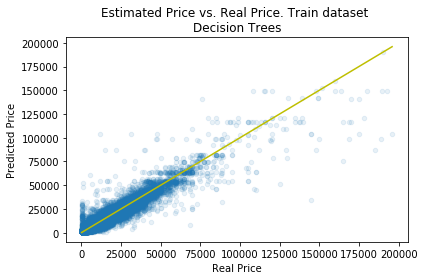

In [158]:
plt.figure(figsize=(6, 4))
plt.scatter(y_train, predBestDTTrain, s=20,alpha=0.1)
plt.title('Estimated Price vs. Real Price. Train dataset \nDecision Trees')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'y')
plt.tight_layout()

Test data

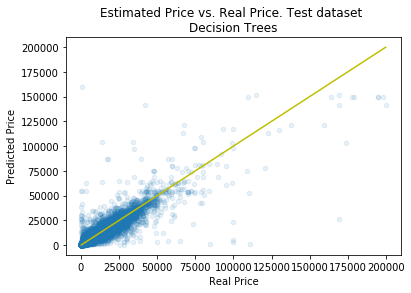

In [159]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predBestDTTest, s=20,alpha=0.1)
plt.title('Estimated Price vs. Real Price. Test dataset \nDecision Trees')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'y')

### Saving the model for later use

In [96]:
joblib.dump(bestDecisionTree, filename='../output/bestDecisionTree.pkl')

['../output/bestDecisionTree.pkl']

***

# Random forest

In [107]:
regrRF = RandomForestRegressor(n_jobs=-1,
                               verbose=1).fit(X_train,
                                              y_train)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [108]:
predRFTrain = regrRF.predict(X_train)
predRFTest = regrRF.predict(X_test)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


* $R^2$ Score:

In [109]:
R2RFTrain = r2_score(y_train, predRFTrain)
R2RFTest = r2_score(y_test, predRFTest)
print('R2 Train: %.3f' % R2RFTrain, '\nR2 Test:  %.3f' % R2RFTest)

R2 Train: 0.970 
R2 Test:  0.872


* MSE Score:

In [111]:
MSERFTrain = mean_squared_error(y_train, predRFTrain)
MSERFTest = mean_squared_error(y_test, predRFTest)
print('MSE Train:', format(MSERFTrain, ',f'), '\nMSE Test:', format(MSERFTest, ',f'))

MSE Train: 1,875,181.259095 
MSE Test: 8,373,979.433170


### Hyperparameter tuning
Test the optimum number of features

In [112]:
np.random.seed(123)
scores = {}

rf = None

for max_features in [2,4,8, 'auto', None]:
    if rf is None:
        rf = RandomForestRegressor(n_estimators=50,
                                   max_features=max_features)
    else:
        rf.warm_start = False
        rf.max_features = max_features
    
    rf = rf.fit(X_train, y_train)
    scores[max_features] = rf.score(X_test, y_test)

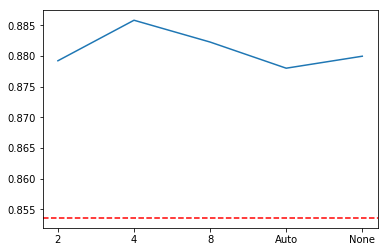

In [121]:
plt.plot([2, 4, 8, 'Auto', 'None'], scores.values())
plt.axhline(bestDecisionTree.score(X_test, y_test), linestyle='dashed', color='red')

In [125]:
paramsRF = {
        'n_estimators': [50, 100, 200],
        'max_features': [4],
        'max_depth': list(range(1, 10 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf':[1]
        }

This param grid takes 1 hours

In [126]:
cvRF = GridSearchCV(
        estimator=RandomForestRegressor(oob_score=True),
        param_grid=paramsRF,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 53.1min finished


In [127]:
cvRF.best_params_

{'max_depth': 10,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [128]:
cvRF.best_score_

0.86518307463441979

In [130]:
bestRandoForest = RandomForestRegressor(max_depth=cvRF.best_params_['max_depth'], 
                                        max_features=cvRF.best_params_['max_features'], 
                                        min_samples_leaf=cvRF.best_params_['min_samples_leaf'], 
                                        min_samples_split=cvRF.best_params_['min_samples_split'], 
                                        n_estimators=cvRF.best_params_['n_estimators']).fit(X_train, y_train)

In [131]:
predBestRFTrain = bestRandoForest.predict(X_train)
predBestRFTest = bestRandoForest.predict(X_test)

* $R^2$ Score:

In [132]:
R2BestRFTrain = r2_score(y_train, predBestRFTrain)
R2BestRFTest = r2_score(y_test, predBestRFTest)
print('R2 Train: %.3f' % R2BestRFTrain, '\nR2 Test: %.3f' % R2BestRFTest)

R2 Train: 0.890 
R2 Test: 0.858


* MSE Score:

In [133]:
MSEBestRFTrain = mean_squared_error(y_train, predBestRFTrain)
MSEBestRFTest = mean_squared_error(y_test, predBestRFTest)
print('MSE Train:', format(MSEBestRFTrain, ',f'), '\nMSE Test:', format(MSEBestRFTest, ',f'))

MSE Train: 6,947,069.623636 
MSE Test: 9,306,430.403108


## Charting results
Train data

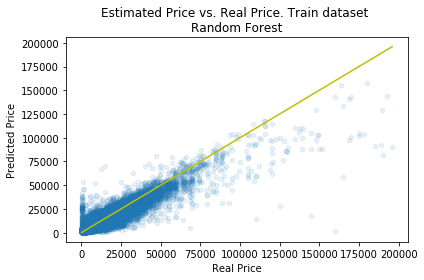

In [160]:
plt.figure(figsize=(6, 4))
plt.scatter(y_train, predBestRFTrain, s=20,alpha=0.1)
plt.title('Estimated Price vs. Real Price. Train dataset \nRandom Forest')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'y')
plt.tight_layout()

Test data

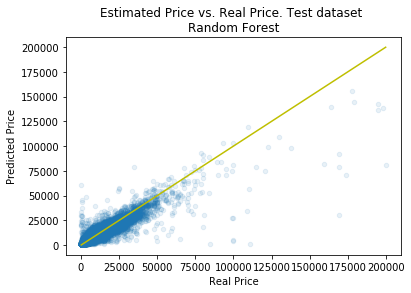

In [161]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predBestRFTest, s=20,alpha=0.1)
plt.title('Estimated Price vs. Real Price. Test dataset \nRandom Forest')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'y')

### Saving the model for later use

In [136]:
joblib.dump(bestRandoForest, filename='../output/bestRandomForest.pkl')

['../output/bestRandomForest.pkl']

***

# K-nearest neighbours

First try

In [178]:
regrKNN = neighbors.KNeighborsRegressor(n_jobs=-1).fit(X_train, y_train)

In [179]:
predKNNTrain = regrKNN.predict(X_train)
predKNNTest = regrKNN.predict(X_test)

* $R^2$ Score:

In [180]:
R2KNNTrain = r2_score(y_train, predKNNTrain)
R2KNNTest = r2_score(y_test, predKNNTest)
print('R2 Train: %.3f' % R2KNNTrain, '\nR2 Test:  %.3f' % R2KNNTest)

R2 Train: 0.910 
R2 Test:  0.840


* MSE Score:

In [181]:
MSEKNNTrain = mean_squared_error(y_train, predKNNTrain)
MSEKNNTest = mean_squared_error(y_test, predKNNTest)
print('MSE Train:', format(MSEKNNTrain, ',f'), '\nMSE Test:', format(MSEKNNTest, ',f'))

MSE Train: 5,713,447.486862 
MSE Test: 10,486,847.513610


In [167]:
# Cross Validation
paramsKNN = {
        'n_neighbors': [5, 10, 20],
        'weights': ['distance', 'uniform'],
        'algorithm': ['auto'],
        'leaf_size': [2,3,4],
        }

This params grid takes 5 minutes

In [168]:
cvKNN = GridSearchCV(
        estimator=neighbors.KNeighborsRegressor(),
        param_grid=paramsKNN,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.8min finished


In [169]:
cvKNN.best_params_

{'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 5, 'weights': 'distance'}

In [170]:
bestKNN = neighbors.KNeighborsRegressor(algorithm=cvKNN.best_params_['algorithm'], 
                                        leaf_size=cvKNN.best_params_['leaf_size'],
                                        n_neighbors=cvKNN.best_params_['n_neighbors'],
                                        weights=cvKNN.best_params_['weights']).fit(X_train, y_train)

In [172]:
predBestKNNTrain = bestKNN.predict(X_train)
predBestKNNTest = bestKNN.predict(X_test)

* $R^2$ Score:

In [173]:
R2BestKNNTrain = r2_score(y_train, predBestKNNTrain)
R2BestKNNTest = r2_score(y_test, predBestKNNTest)
print('R2 Train: %.3f' % R2BestKNNTrain, '\nR2 Test: %.3f' % R2BestKNNTest)

R2 Train: 0.986 
R2 Test: 0.857


* MSE Score:

In [174]:
MSEBestKNNTrain = mean_squared_error(y_train, predBestKNNTrain)
MSEBestKNNTest = mean_squared_error(y_test, predBestKNNTest)
print('MSE Train:', format(MSEBestKNNTrain, ',f'), '\nMSE Test:', format(MSEBestKNNTest, ',f'))

MSE Train: 872,528.983937 
MSE Test: 9,413,727.364283


## Charting results
Train data

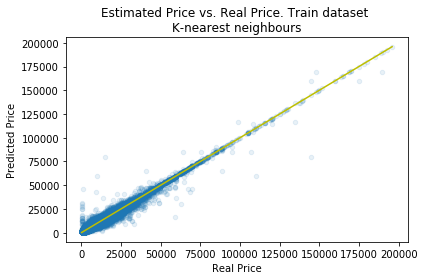

In [175]:
plt.figure(figsize=(6, 4))
plt.scatter(y_train, predBestKNNTrain, s=20,alpha=0.1)
plt.title('Estimated Price vs. Real Price. Train dataset \nK-nearest neighbours')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'y')
plt.tight_layout()

Test data

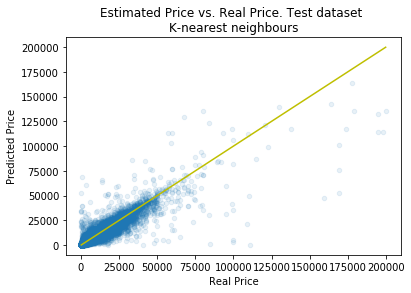

In [176]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predBestKNNTest, s=20,alpha=0.1)
plt.title('Estimated Price vs. Real Price. Test dataset \nK-nearest neighbours')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'y')

### Saving the model for later use

In [177]:
joblib.dump(bestKNN, filename='../output/bestKNN.pkl')

['../output/bestKNN.pkl']